### prepair modules and bases settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,  classification_report, log_loss
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
import scipy.io
import re
import itertools

import os
from os.path import join
import contextlib
from copy import deepcopy
import imp 
import time 
import sys

In [4]:
# Add the directory containing your modules to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'ses2_modelstims')))

# load local functions
import stim_io
import stim_io_plotting
import vtc

/home/jorvhar/miniconda3/envs/predlis/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


## 1. Set up regresiion model
Options:

In [8]:
## OVERALL OPTIONS ##
save_predict = True           # save y_pred-y
score_of_interest = 'score'

SD_lim = 3                    # remove y x sd higher then mean
remove_outliers = False       # if false dont remove sd outliers 

z_score_x = True              
z_score_y = True              
z_score_scope = 2             # 1:over all, 2:within run, 3:within block

meanormedian = 'mean'         # mean makes varpart linear 

## OPTIONS ##
ppz = [1,2]
n_splitsz = [6,               # 12 runs > 10:2cross, 6 fold
             6]               # splits used per pp (for variable length option) 

# all 3 models
models = ['base',
          'adaptation',
          'prediction',
          'base_U_adaptation',
          'base_U_prediction',
          'adaptation_U_prediction',
          'base_U_adaptation_U_prediction']
# if we want to use 2models: 
models=['base_U_adaptation', 'prediction', 'base_U_adaptation_U_prediction']

## REGRESSORS IN MODELS ##
model_regressors = {'base':       ['raw_acti', 'onoff'], 
                    'adaptation': ['raw_adapt' ],      # adaptation
                    'prediction': ['pred_prob',   # voxelwise prior liklihood
                                   'surprisal']   # global prior surprise
                   } 
# if we want to add adapted activation
# model_regressors['adaptation'] += ['adapt_activ']

# set combination of regressors
model_regressors.update({'base_U_adaptation':             model_regressors['base']+
                                                          model_regressors['adaptation'],
                        'base_U_prediction':              model_regressors['base']+
                                                          model_regressors['prediction'], 
                        'adaptation_U_prediction':        model_regressors['adaptation']+
                                                          model_regressors['prediction'], 
                        'base_U_adaptation_U_prediction': model_regressors['base']+
                                                          model_regressors['adaptation']+
                                                          model_regressors['prediction']})
y_var = 'voxeltimecourse'

### loading input data

In [9]:
zs=lambda x: (x-x.mean(0)) /x.std(0)
corr_column= lambda a,b: (zs(a)*zs(b)).mean(0)
def zs_prior(x, prior_entr):
    return((prior_entr-x.mean(0)) /x.std(0))

def train_test_splits(df, n_splits, shuffle=True, random_state=123, group='run'):
    """ Main function for getting an array of train test splits
    
    input: df        : pandas dataframe, to obtain 'group' from
           n_splits  : number of train/test splits (k-folds)
           shuffle   : (default true) whether to shuffle KFolds
           random_state : (default 123) the random seed to use
           group     : (default 'run') the group to use for splitting
    
    returns: training indexes : [n_splits * groups in training]
             testing_indexes  : [n_splits * groups in testing]"""

    # use sklearn tool for getting kfolds
    kf = KFold(n_splits=n_splits, 
               shuffle=True,
               random_state=123)

    # get runs
    runz = df['run'].unique()

    # save empty list for train and test texts
    train_indexes = np.empty((0, int(len(runz)-len(runz)/n_splits)), int)
    test_indexes = np.empty((0, int(len(runz)/n_splits)), int)

    # loop for text in folds
    for train_index, test_index in kf.split(runz):
        train_indexes = np.append(train_indexes, 
                                  np.array([runz[train_index]]), 
                                  axis=0)
        test_indexes = np.append(test_indexes,
                                 np.array([runz[test_index]]),
                                 axis=0)
        
    # return train and test indexes
    return(train_indexes, test_indexes)
    
    
def model_fit(model, X_train,X_test,y_train,y_test, save_predict=False):
    """take the linear model, the train/test data and do scoring
    input:  model:    input model type
            X_train:  regressor input train data
            X_test:   regressor input test data
            y_train:  target train data
            y_test:   target test data
            save_predict:   save individual trail-by-trail predictions
    output: return scores dictionary
    """
    scores = {}
    
    # fit model, get y_pred, model proba and nullmodel proba
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # get model score, classification report, confustion matrix and coefs/intercepts
    scores['score'] = np.array([model.score(X_test, y_test)]) # place in array to make chunking easier
    scores['raw_scores'] = r2_score(y_test, y_pred, multioutput='raw_values')
    scores['coefs'] = model.coef_[:]
    scores['intercepts'] = model.intercept_
    scores['correlation'] = corr_column(y_test, y_pred)
    
    # save prediction scores if flagged
    if save_predict:
        scores['predict'] = {'y_pred': y_pred, 'y': y_test}
    
    # return cross validated scores
    return(scores)


def non_cv_fit(model, X, y, save_predict=False):
    """take the linear model, the train/test data and do scoring
    input:  model:    input model type
            X:        regressors
            y:        target var
            save_predict:   save individual trail-by-trail predictions
    output: return scores dictionary
    """
    scores = {}
    
    # fit model, get y_pred, model proba and nullmodel proba
    model.fit(X, y)
    y_pred = model.predict(X)
    #scores['modelproba'] = model.predict_proba(X)
    #scores['nullproba'] = pred_proba_null(y)
    
    # get model score, classification report, confustion matrix and coefs/intercepts
    scores['score'] = model.score(X, y)
    scores['raw_scores'] = r2_score(y, y_pred, multioutput='raw_values')
    #scores['conf_mat'] = (confusion_matrix(y, y_pred).T / confusion_matrix(y, y_pred).sum(axis=1)).T
    scores['coefs'] = model.coef_[:]
    scores['intercepts'] = model.intercept_
    scores['correlation'] = corr_column(y, y_pred)
    
    # save prediction scores if flagged
    if save_predict:
        scores['predict'] = {'y_pred': y_pred, 'y': y}
    
    # return scores    
    return(scores)

def zs_per_run(x, runs):
    """z-score x/y in dimension 1 given a list of runs of same length
    e.g. if x = (2820, 5) then runs should be shape (2820) giving the indexes of runs
    the resulting x is in this case zscored in the '2820' direction, devided in runs"""

    # z-scoring across the zerod axis
    zs=lambda i: (i-i.mean(0)) /i.std(0)

    # z-score per run
    for run in np.unique(runs):
        x[runs == run] = zs(x[runs == run])
    # get rid of nans and return
    return(np.nan_to_num(x))

def extract_sublist(lst, prefixes):
    return [item for item in lst for prefix in prefixes if re.match(f"^{prefix}", item)]

### mask and vmp file loading

In [11]:
## MOSTLY EXAMPLE FUNCTION??

import bvbabel
import vtc

mridat_dir = '/media/jorvhar/Data8T/MRIData/PreProc'
vtc_dir = '/media/jorvhar/New Volume1/vtcs' # adviced to put vtc's on a (nvme) ssd while running analyses
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
betas_dir = 'Betas'

# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations.vmp'
mask_fn = 'brainmask.msk'

# chunking settings
chunksize = 50000   # msk[0].shape[0]
pp = 1
ses = 2

# fn lambda
fn = lambda pp, ses, run : f'S{pp:02d}_SES{ses}_run{run}_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc'

# create full path
mskpath = join(mridat_dir, pp_dir(pp,1), mask_fn)
vmppath = join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp)

# load full mask and convert to indeces
_, msk = bvbabel.msk.read_msk(mskpath)
msk = np.where(msk)
# devide the mask in chucks based on our chucksize
chunked_msk = vtc.chunk_msk(msk, chunksize)

# load vmp image
vmp_head, vmp_img = bvbabel.vmp.read_vmp(vmppath)

In [228]:
## LOOP OVER TW AND TPREFS GET INDEXES OF PRF MAPPING


# tonotopy and mask filenames
mask_fn = 'brainmask.msk'
# create full path
mskpath = join(mridat_dir, pp_dir(pp,1), mask_fn)
# load full mask and convert to indeces
_, msk = bvbabel.msk.read_msk(mskpath)
msk = np.where(msk)


# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations.vmp'
# load vmp image
score_vmp_head, vmp_placeholder = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp))
score_vmp_full = np.zeros((list(vmp_placeholder.shape[:-1]) + [3 * 4]))
score_vmp_head['NrOfSubMaps'] = 2
score_vmp_head['Map'] = []
score_vmp = np.zeros(vmp_placeholder.shape[:3])

# load tonotopy vmp
vmp_df = pd.DataFrame(vmp_img[msk])

# create grid and do full loop
for tpref, tw in itertools.product(pref_range, sharp_range):

    # get grid position indexes for tuning pref and tw
    grid_idx = vmp_df.loc[np.isclose(vmp_df[0], tpref, rtol=1e-3) & 
                          np.isclose(vmp_df[1], tw, rtol=1e-3)].index
    # this is a linear index
    
    # check if any boxels in gridposition
    if grid_idx.empty == False:
        
        # use these grid positions to get a chuck of the mask
        msk_chunk = [i[grid_idx] for i in msk]
        
        pred = tr_df[f'pred_prob_{tpref:.3f}_convolved'].iloc[100]
        actv = tr_df[f'raw_acti_{tpref:.3f}_{tw:.3f}_convolved'].iloc[100]
        score_vmp[msk_chunk] = pred
    
    
#     score_vmp_full[:,:,:,val] = score_vmp
    
    
  ## SETUP FOR ALL, FIRST TRY WITH ONE...

#     idxz = [1775, 1782, 1790, 1797]
#     for idx in range(len(idxz)):
        
#         # get current tw tpref expected
#         pred = tr_df[f'pred_prob_{tpref:.3f}_convolved'].iloc[idxz[idx]]
#         actv = tr_df[f'raw_acti_{tpref:.3f}_{tw:.3f}_convolved'].iloc[idxz[idx]]
#         adpt = tr_df[f'raw_adapt_{tpref:.3f}_{tw:.3f}_convolved'].iloc[idxz[idx]]

#         #full map
#         valz = [pred, actv, adpt]
#         for val in range(len(valz)):
#             score_vmp[grid_idx] = valz[val]
#             score_vmp_full[:,:,:,val] = score_vmp


    
    
    #score_vmp_head['Map'].append(set_map('pred', mapthreshold=0, mapupperthreshold=10))

    #bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S0{}_SES1/Betas/map2023-1.vmp'.format(pp),score_vmp_head, score_vmp_full)



In [ ]:
## THERE SEEMS TO BE AN ERROR WITH THE GETHERING OF LOCATIONS, DOUBLE CHECK IF THIS ALL IS WORKING CORRECTLY
# seems that there is only one predictior for the whole field, which isnt right, make sure this is fixed for eventual analysis!

In [230]:
def set_map(mapname, mapthreshold=1.65, mapupperthreshold=8.0):
    FDRTableInfo = np.array([], dtype=np.float64)
    FDRTableInfo.shape = (0,3)
    returnmap = {'TypeOfMap': 1,
     'MapThreshold': mapthreshold,
     'UpperThreshold': mapupperthreshold,
     'MapName': mapname,
     'RGB positive min': np.array([255,   0,   0], dtype=np.uint8),
     'RGB positive max': np.array([255, 255,   0], dtype=np.uint8),
     'RGB negative min': np.array([255,   0, 255], dtype=np.uint8),
     'RGB negative max': np.array([  0,   0, 255], dtype=np.uint8),
     'UseVMPColor': 0,
     'LUTFileName': '<default>',
     'TransparentColorFactor': 1.0,
     'ClusterSizeThreshold': 50,
     'EnableClusterSizeThreshold': 0,
     'ShowValuesAboveUpperThreshold': 1,
     'DF1': 249,
     'DF2': 1,
     'ShowPosNegValues': 3,
     'NrOfUsedVoxels': 45555,
     'SizeOfFDRTable': 0,
     'FDRTableInfo': FDRTableInfo,
     'UseFDRTableIndex': 0}
    return(returnmap)

# full map
score_vmp_full[:,:,:,0] = score_vmp
score_vmp_head['Map'].append(set_map('pred', mapthreshold=0, mapupperthreshold=10))

bvbabel.vmp.write_vmp('/media/jorvhar/Data8T/MRIData/PreProc/S0{}_SES1/Betas/test-1.vmp'.format(pp),score_vmp_head, score_vmp_full)

### reconstruction of image
(for testing)

y shape: (50000, 2350)	 run_nr shape: (2350,)


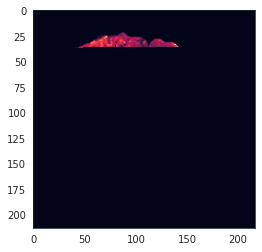

In [44]:
# get vtc filenames
runz = [1,2,3,4,5,6,7,8,9,10]
vtc_fns = [join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run)) for run in runz]

# load vtc chunks
y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, chunked_msk[0])
print(f'y shape: {y.shape}\t run_nr shape: {run_nr.shape}')

# senity check to display a chunk
n_img = stim_io.reconstruct_vtc(y[:,run_nr==5], chunked_msk[0], 
                                vtc_for_header=vtc_fns[0]) # or None
plt.imshow(n_img[:,:,40,100])

In [128]:
tr_df.iloc[1797]

frequencies                                    NaN
frequencies_oct                                NaN
timing                                2.518451e+06
closest_volume_rel                    1.510000e+02
closest_volume_abs                    1.796000e+03
                                          ...     
adapt_activ_12.469_3.397_convolved             NaN
adapt_activ_12.489_3.397_convolved             NaN
adapt_activ_12.510_3.397_convolved             NaN
adapt_activ_12.530_3.397_convolved             NaN
adapt_activ_12.551_3.397_convolved             NaN
Name: 13217, Length: 22340, dtype: float64

## Doing the regressions
(testing for single tpref and tw - chunked regressions)

In [29]:
# # quick settings
# n_splits = 6  #6
# tpref = 9.9228
# tw = 0.755
# convolved = True

# # get vtc filenames and settings
# runz = [1,2,3,4,5,6,7,8,9,10,11,12]
# save_predict = False

# # set modeltype
# modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.
# key_ai = ['raw_scores', 'coefs', 'intercepts', 'correlation'] # what keys to median and mean across folds


# ## --- DEFINING TEST TRAIN SPLIT ---

# # get test train splits per run
# train_matrix, test_matrix = train_test_splits(stim_df, n_splits)


# ## --- BASED ON TUNING PREF AND TW LOAD DESIRED COLUMNS OUT OF DF ---

# # load (all) xnames
# col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)

# # load voxeltimecourse filenames
# vtc_fns = [join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run)) for run in runz]

# # predefine dictionaries for saving regression results
# scores = {}


# # --- LOOP OVER CHUCKS TO MANAGE MEMORY ---
# for curchunk in range(len(chunked_msk)):
    
#     # load vtc for chunk
#     y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, chunked_msk[curchunk])
#     y = y.transpose() # transpose to make k-fold splits simpler

    
# # --- LOOP OVER ALL MODELS FOR DOING SET THEORY --- 
#     for model in models:

#         # get X for this model 
#         col_regressors = extract_sublist(col_names, model_regressors[model])
#         X = tr_df[col_regressors].to_numpy()
#         print(f'{model}:\n\t\t{extract_sublist(col_names, model_regressors[model])}\n')

#         # (re)predefine dictionary for storing this models all folds
#         nscore = {}
        
        
# ### --- RUN SCRIPT TO DO KFOLDED REGRESSION, AND PARSE OUTPUT IN MEANINGFULL WAY
#         # get cross validated scores based on previously defined test/train splits
#         for fold in range(len(train_matrix)):
#             # save indexes for text number in array
#             train_idx = np.argwhere(np.in1d(run_nr, train_matrix[fold])).flatten()
#             test_idx = np.argwhere(np.in1d(run_nr, test_matrix[fold])).flatten()

#             # select train and test sets for fold
#             X_train, X_test = X[train_idx], X[test_idx]
#             y_train, y_test = y[train_idx], y[test_idx]

#             # do the regression
#             nscore[fold+1] = model_fit(modeltype, 
#                                        X_train,
#                                        X_test,
#                                        y_train,
#                                        y_test,
#                                        save_predict=save_predict)
            
#         # check if we update previous chunk or initate dict using this one
#         if model not in scores:
#             scores[model] = nscore
#         else:
#             # combine all the folds into one dictionary - aditionally append chunks
#             for fold in range(len(train_matrix)):
#                 scores[model][fold+1] = {key : np.concatenate((scores[model][fold+1][key], 
#                                                                nscore[fold+1][key])) for key in nscore[fold+1]}
                
#         # store median and mean across folds
#         for k in key_ai:
#             cv_scores = {'median':  np.median(np.array([scores[model][fold+1][k] for 
#                                                         fold in range(len(train_matrix))]), axis=0),
#                          'mean':   np.nanmean(np.array([scores[model][fold+1][k] for 
#                                                         fold in range(len(train_matrix))]), axis=0)}
#             scores[model][k] = cv_scores
            
            
# ### --- DO ANOTHER REGRESSION WITHOUT CROSS VALIDATION, TO VALIDATE RESULTS
#         # get non-crossvalidated scores
#         scores[model]['non-cv'] = non_cv_fit(modeltype, 
#                                                 X,
#                                                 y,
#                                                 save_predict=save_predict)

## Full regression
- using tpref and tw from vmp file

In [49]:
origin_fns = [join(mridat_dir, pp_dir(pp, ses), fn(pp,ses,run)) for run in runz]
vtc_fns = [join(vtc_dir, fn(pp,ses,run)) for run in runz]

# copy to ssd for efficient chunk processing
stim_io.copy_files(origin_fns, vtc_fns)

Copied /media/jorvhar/Data8T/MRIData/PreProc/S03_SES2/S03_SES2_run1_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc to /media/jorvhar/New Volume1/vtcs/S03_SES2_run1_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc
Copied /media/jorvhar/Data8T/MRIData/PreProc/S03_SES2/S03_SES2_run2_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc to /media/jorvhar/New Volume1/vtcs/S03_SES2_run2_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc
Copied /media/jorvhar/Data8T/MRIData/PreProc/S03_SES2/S03_SES2_run3_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc to /media/jorvhar/New Volume1/vtcs/S03_SES2_run3_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc
Copied /media/jorvhar/Data8T/MRIData/PreProc/S03_SES2/S03_SES2_run4_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc to /media/jorvhar/New Volume1/vtcs/S03_SES2_run4_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc
Copied /media/jorvhar/Data8T/MRIData/PreProc/S03_SES2/S03_SES2_run5_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc to /media/jorvhar/New Volume1/vtcs/S03_SES2_run5_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc
Copied /media/jorvhar/Data8T/MRIData/PreProc/

then run the full regression 

In [45]:
# quick settings
n_splits = 5  #6
convolved = True

# get vtc filenames and settings
runz = [1,2,3,4,5,6,7,8,9,10]
save_predict = False

# set modeltype
modeltype = LinearRegression() #can be LinearRegression (ols), Ridge(alpha=..), Lasso(alpha=..)  etc.
key_ai = ['raw_scores', 'coefs', 'intercepts', 'correlation'] # what keys to median and mean across folds


## --- DEFINING TEST TRAIN SPLIT ---

# get test train splits per run
train_matrix, test_matrix = train_test_splits(stim_df, n_splits)


## --- BASED ON TUNING PREF AND TW LOAD DESIRED COLUMNS OUT OF DF ---

# load tonotopy vmp
vmp_df = pd.DataFrame(vmp_img[msk])

# load voxeltimecourse filenames
vtc_fns = [join(vtc_dir, fn(pp,ses,run)) for run in runz]

# predefine dictionaries for saving regression results
scores = {}

# predifine indexes arrays for reconstruction
idx1 = np.array([], dtype=int)
idx2 = np.array([], dtype=int)
idx3 = np.array([], dtype=int)

## --- LOOP OVER FULL GRID OF PREFS * TWS ---

# create grid and do full loop
for tpref, tw in itertools.product(pref_range, sharp_range):
    # TEMP FOR TIMING
    st_temp = time.time() #start timing

    # get grid position indexes for tuning pref and tw
    grid_idx = vmp_df.loc[np.isclose(vmp_df[0], tpref, rtol=1e-3) & 
                          np.isclose(vmp_df[1], tw, rtol=1e-3)].index
    
    # check if any boxels in gridposition
    if grid_idx.empty == False:
        
        # use these grid positions to get a chuck of the mask
        msk_chunk = [i[grid_idx] for i in msk]

        # load vtc for chunk
        y, run_nr = stim_io.load_vtc_chunk_runs(vtc_fns, msk_chunk)
        y = y.transpose() # transpose to make k-fold splits simpler

        # zscore y
        y = zs_per_run(y, run_nr)
        
        # load xnames for this columns
        col_names = stim_io.get_tw_collumns(tr_df, tpref, tw, convolved=convolved)
        
        # translate grid positions to mask indexes and save full list
        idx1 = np.concatenate((idx1, msk[0][grid_idx]))
        idx2 = np.concatenate((idx2, msk[1][grid_idx]))
        idx3 = np.concatenate((idx3, msk[2][grid_idx]))

# --- LOOP OVER ALL MODELS FOR DOING SET THEORY --- 
        for model in models:

            # get X for this model 
            col_regressors = extract_sublist(col_names, model_regressors[model])
            X = tr_df[col_regressors].to_numpy()
            #print(f'{model}:\n\t\t{extract_sublist(col_names, model_regressors[model])}\n')

            # zscore y
            X = zs_per_run(X, run_nr)
            
            # (re)predefine dictionary for storing this models all folds
            nscore = {}
        
        
### --- RUN SCRIPT TO DO KFOLDED REGRESSION, AND PARSE OUTPUT IN MEANINGFULL WAY
            # get cross validated scores based on previously defined test/train splits
            for fold in range(len(train_matrix)):
                # save indexes for text number in array
                train_idx = np.argwhere(np.in1d(run_nr, train_matrix[fold])).flatten()
                test_idx = np.argwhere(np.in1d(run_nr, test_matrix[fold])).flatten()

                # select train and test sets for fold
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # do the regression
                nscore[fold+1] = model_fit(modeltype, 
                                           X_train,
                                           X_test,
                                           y_train,
                                           y_test,
                                           save_predict=save_predict)

            # check if we update previous chunk or initate dict using this one
            if model not in scores:
                scores[model] = nscore
            else:
                # combine all the folds into one dictionary - aditionally append chunks
                for fold in range(len(train_matrix)):
                    scores[model][fold+1] = {key : np.concatenate((scores[model][fold+1][key], 
                                                                   nscore[fold+1][key])) for key in nscore[fold+1]}


### --- DO ANOTHER REGRESSION WITHOUT CROSS VALIDATION, TO VALIDATE RESULTS ---
            # get non-crossvalidated scores
            nscore_noncv = non_cv_fit(modeltype, 
                                        X,
                                        y,
                                        save_predict=save_predict)
            # nest 'score' inside an array to allow for concatenation
            nscore_noncv['score'] = np.array([nscore_noncv['score']]) 
            # check if exist otherwise add to existing
            if 'non-cv' not in scores[model]:
                scores[model]['non-cv'] = nscore_noncv
            else:
                scores[model]['non-cv'] = {key : np.concatenate((scores[model]['non-cv'][key], 
                                                                 nscore_noncv[key])) for key in nscore_noncv}


### --- STORE MEDIAN AND MEAN ACROSS FOLDS ---
for model in models:
    for k in key_ai:
        cv_scores = {'median':  np.median(np.array([scores[model][fold+1][k] for 
                                                    fold in range(len(train_matrix))]), axis=0),
                     'mean':   np.nanmean(np.array([scores[model][fold+1][k] for 
                                                    fold in range(len(train_matrix))]), axis=0)}
        scores[model][k] = cv_scores
    
# save indexes
scores['indexes'] = (idx1, idx2, idx3)

KeyError: 'base_U_adaptation'

In [32]:
# remove files
for fp in vtc_fns:
    os.remove(fp)

cleanup and saving

In [33]:
import pickle

# make dir if doesnt esist
if not os.path.exists(join(mridat_dir, pp_dir(pp, ses), 'Betas')):
    os.mkdir(join(mridat_dir, pp_dir(pp, ses), 'Betas'))

# pickle the results
with open(join(mridat_dir, pp_dir(pp, ses), 'Betas/scores.pickle'), 'wb') as handle:
    pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

loading

In [34]:
with open(join(mridat_dir, pp_dir(pp, ses), 'Betas/scores.pickle'), 'rb') as handle:
    scores = pickle.load(handle)

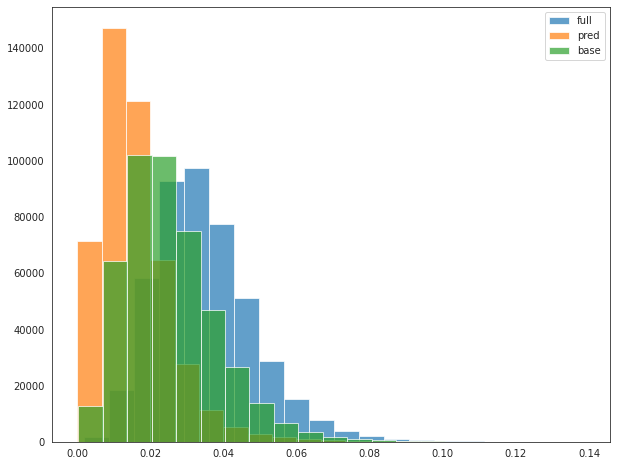

In [35]:
plt.figure(figsize=(10, 8))

plt.hist(scores['base_U_adaptation_U_prediction']['non-cv']['correlation'], 20, alpha=0.7, label='full')
plt.hist(scores['prediction']['non-cv']['correlation'], 20, alpha=.7, label='pred')
plt.hist(scores['base_U_adaptation']['non-cv']['correlation'], 20, alpha=.7, label='base')
plt.legend()

In [36]:
def set_map(mapname, mapthreshold=1.65, mapupperthreshold=8.0):
    FDRTableInfo = np.array([], dtype=np.float64)
    FDRTableInfo.shape = (0,3)
    returnmap = {'TypeOfMap': 1,
     'MapThreshold': mapthreshold,
     'UpperThreshold': mapupperthreshold,
     'MapName': mapname,
     'RGB positive min': np.array([255,   0,   0], dtype=np.uint8),
     'RGB positive max': np.array([255, 255,   0], dtype=np.uint8),
     'RGB negative min': np.array([255,   0, 255], dtype=np.uint8),
     'RGB negative max': np.array([  0,   0, 255], dtype=np.uint8),
     'UseVMPColor': 0,
     'LUTFileName': '<default>',
     'TransparentColorFactor': 1.0,
     'ClusterSizeThreshold': 50,
     'EnableClusterSizeThreshold': 0,
     'ShowValuesAboveUpperThreshold': 1,
     'DF1': 249,
     'DF2': 1,
     'ShowPosNegValues': 3,
     'NrOfUsedVoxels': 45555,
     'SizeOfFDRTable': 0,
     'FDRTableInfo': FDRTableInfo,
     'UseFDRTableIndex': 0}
    return(returnmap)

In [37]:
lookup = np.array([[0.33, 0.33,0.34],
                [0.264, 0.264,0.472],
                [0.198, 0.198,0.604],
                [0.132, 0.132,0.736],
                [0.066, 0.066,0.868],
                [0, 0,1],
                [0.1225, 0,0.8775],
                [0.245,0,0.755],
                [0.3675,0,0.6325],
                [0.49,0,0.51],
                [0.34,0.33,0.33],
                [0.472,0.264,0.264],
                [0.604,0.198,0.198],
                [0.736,0.132,0.132],
                [0.868,0.066,0.066],
                [1,0,0],
                [0.8775,0,0.1225],
                [0.755,0,0.245],
                [0.6325,0,0.3675],
                [0.51,0,0.49]])

In [38]:
lookup = np.array([[1,0,0],
              [0.833333333333333,0.166666666666667,0],
              [0.666666666666667,0.333333333333333,0],
              [0.5,0.5,0],
              [0.25,0.75,0],
              [0,1,0],
              [0,0.75,0.25],
              [0,0.5,0.5],
              [0,0.333333333333333,0.666666666666667],
              [0,0.166666666666667,0.833333333333333],
              [0,0,1],
              [0.166666666666667,0,0.833333333333333],
              [0.333333333333333,0,0.666666666666667],
              [0.5,0,0.5],
              [0.833333333333333,0,0.166666666666667],
              [0.666666666666667,0,0.333333333333333],
              [0.333,0.333,0.333],
              [0.1665,0.1665,0.6665],
              [0.6665,0.1665,0.1665],
              [0.1665,0.6665,0.1665]])
    
def closest_row(lookup, coord):
    """quick function so search for the closest coordinate in the lookup table
    then convert this to the -10 +10 range of brainvoyager"""
    lookup = np.array(lookup)
    coords = np.array(coord)
    bv_value = np.concatenate((np.arange(1,11,1), np.arange(-1,-11,-1)))
    distances = np.linalg.norm(lookup[np.newaxis, :, :] - coords[:, np.newaxis, :], axis=2)
    return bv_value[np.argmin(distances, axis=1)]

In [39]:
# set theory calculations
pred_unique = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - scores['base_U_adaptation']['non-cv']['raw_scores']
base_unique = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - scores['prediction']['non-cv']['raw_scores']
common_part = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - pred_unique - base_unique

# take full matrix and stack/normalize
full_mat = np.stack((pred_unique, common_part, base_unique)) # stack 3 parts of sets
full_mat = full_mat.clip(min=0) / full_mat.clip(min=0).sum(axis=0)  # normalize matrix

# get -10 10 range
map_val = closest_row(lookup, full_mat.transpose())

# so some sellection
sellection = scores['base_U_adaptation_U_prediction']['non-cv']['correlation'] < 0.05
map_val[sellection] = 0

In [40]:
## stranslate data to vmp

# pp = 2
nr_models = 1

# filenames
mridat_dir = '/media/jorvhar/Data1/MRIData/PreProc'
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
betas_dir = 'Betas'

# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations_for_S2.vmp'

# load vmp image
score_vmp_head, vmp_img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp))
score_vmp_full = np.zeros((list(vmp_img.shape[:-1]) + [nr_models * 2]))
score_vmp_head['NrOfSubMaps'] = nr_models
score_vmp_head['Map'] = []

# full map
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = map_val
score_vmp_full[:,:,:,0] = score_vmp
score_vmp_head['Map'].append(set_map('pred', mapthreshold=0, mapupperthreshold=10))

bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S0{}_SES1/Betas/map2023-1.vmp'.format(pp),score_vmp_head, score_vmp_full)

In [41]:
sellection = scores['base_U_adaptation_U_prediction']['non-cv']['correlation'] < 0.035
full_mat[:,sellection] = 0

np.round(full_mat[0,:] * 10)  # prediction map
np.round(full_mat[1,:] * 10)  # common map
np.round(full_mat[2,:] * 10)  # baseline map


array([8., 8., 5., ..., 0., 0., 7.])

In [42]:
## stranslate data to vmp

# pp = 1
nr_models = 3

# filenames
mridat_dir = '/media/jorvhar/Data1/MRIData/PreProc'
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
betas_dir = 'Betas'

# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations_for_S2.vmp'

# load vmp image
score_vmp_head, vmp_img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp))
score_vmp_full = np.zeros((list(vmp_img.shape[:-1]) + [nr_models * 2]))
score_vmp_head['NrOfSubMaps'] = nr_models
score_vmp_head['Map'] = []

# full map
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = np.round(full_mat[0,:] * 10)
score_vmp_full[:,:,:,0] = score_vmp
score_vmp_head['Map'].append(set_map('pred', mapthreshold=0, mapupperthreshold=10))

# full map
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = np.round(full_mat[1,:] * 10)
score_vmp_full[:,:,:,1] = score_vmp
score_vmp_head['Map'].append(set_map('common', mapthreshold=0, mapupperthreshold=10))

# full map
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = np.round(full_mat[2,:] * 10)
score_vmp_full[:,:,:,2] = score_vmp
score_vmp_head['Map'].append(set_map('baseline', mapthreshold=0, mapupperthreshold=10))

bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S0{}_SES1/Betas/map1234.vmp'.format(pp),score_vmp_head, score_vmp_full)

In [43]:
## stranslate data to vmp

# pp = 1
nr_models = 6
multiplyer = 50 # for floating point errros, use multiplyer

# filenames
mridat_dir = '/media/jorvhar/Data1/MRIData/PreProc'
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
betas_dir = 'Betas'

# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations_for_S2.vmp'

# load vmp image
score_vmp_head, vmp_img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp))
score_vmp_full = np.zeros((list(vmp_img.shape[:-1]) + [nr_models * 2]))
score_vmp_head['NrOfSubMaps'] = nr_models * 2
score_vmp_head['Map'] = []

#############################
# FIRST DO EVERYTHING NON-CV
#############################

# set theory calculations
pred_unique = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - scores['base_U_adaptation']['non-cv']['raw_scores']
base_unique = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - scores['prediction']['non-cv']['raw_scores']
common_part = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - pred_unique - base_unique

# base model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation']['non-cv']['raw_scores'] * multiplyer
score_vmp_full[:,:,:,0] = score_vmp
score_vmp_head['Map'].append(set_map('base_U_adaptation (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# pred model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['prediction']['non-cv']['raw_scores'] * multiplyer
score_vmp_full[:,:,:,1] = score_vmp
score_vmp_head['Map'].append(set_map('prediction (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# full model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] * multiplyer
score_vmp_full[:,:,:,2] = score_vmp
score_vmp_head['Map'].append(set_map('base_U_adaptation_U_prediction (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# base unique
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = base_unique * multiplyer
score_vmp_full[:,:,:,3] = score_vmp
score_vmp_head['Map'].append(set_map('base_unique (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# pred unique
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = pred_unique * multiplyer
score_vmp_full[:,:,:,4] = score_vmp
score_vmp_head['Map'].append(set_map('pred_unique (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# shared
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = common_part * multiplyer
score_vmp_full[:,:,:,5] = score_vmp
score_vmp_head['Map'].append(set_map('base_N_adaptation_N_prediction (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))


#####################################
# do same on cross validated results
#####################################

# set theory calculations
pred_unique = scores['base_U_adaptation_U_prediction']['raw_scores']['mean'] - scores['base_U_adaptation']['raw_scores']['mean']
base_unique = scores['base_U_adaptation_U_prediction']['raw_scores']['mean'] - scores['prediction']['raw_scores']['mean']
common_part = scores['base_U_adaptation_U_prediction']['raw_scores']['mean'] - pred_unique - base_unique

# base model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation']['raw_scores']['mean'] * multiplyer
score_vmp_full[:,:,:,6] = score_vmp
score_vmp_head['Map'].append(set_map('base_U_adaptation (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# pred model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['prediction']['raw_scores']['mean'] * multiplyer
score_vmp_full[:,:,:,7] = score_vmp
score_vmp_head['Map'].append(set_map('prediction (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# full model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation_U_prediction']['raw_scores']['mean'] * multiplyer
score_vmp_full[:,:,:,8] = score_vmp
score_vmp_head['Map'].append(set_map('base_U_adaptation_U_prediction (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# base unique
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = base_unique * multiplyer
score_vmp_full[:,:,:,9] = score_vmp
score_vmp_head['Map'].append(set_map('base_unique (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# pred unique
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = pred_unique * multiplyer
score_vmp_full[:,:,:,10] = score_vmp
score_vmp_head['Map'].append(set_map('pred_unique (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# shared
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = common_part * multiplyer
score_vmp_full[:,:,:,11] = score_vmp
score_vmp_head['Map'].append(set_map('base_N_adaptation_N_prediction (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S0{}_SES2/Betas/session2.vmp'.format(pp),score_vmp_head, score_vmp_full)

In [44]:
baseidx = np.where(map_val == 7)[0][100] # index pure baseline
mixidx = np.where(map_val == -1)[0][100] # fully mixed
predidx = np.where(map_val == -6)[0][0] # pure prediction
predbaseidx = np.where(map_val == 10)[0][100] # pred + adapt


### variance partitioning

In [45]:
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3
import numpy as np 

def two_way_varpart(A,B,AuB,correct_R2s=True,return_sep=True):
    """2-way variance partitioning. Handles scalars (single R2s) and vectors (multiple R2s).
    
    By default, this function implements a correction to handle cross-validated R2s. 
    That is, estimates and adds the smallest bias vector (in an L2-sense) such that the 
    set theoretic equations yield no inconsistent results. See De Heer, Huth, et al. 
    
    For info, see:
    - de Heer, Huth, et al. (2017) Journal of Neuroscience, 37(27), 6539-6557.

    In:
    positional args: 
    - (A,B,AuB): floats or np.array, shape(n_resp)
        R2 values for GLMs with each feature space, and the union of them. 
    - return_sep: bool (Default: True)
        if True, returns separate variable for each partition (i.e. as tuple of scalars/vectors)  
        If False, returns values in vectorised form (i.e. vector of scalars / matrix of row-vectors)
    -correct_R2s: Bool (Default: True)
        Implement correction to avoid impossible values.
    
    Out:
    - 6 separate variables for each (adjusted) input R2 and each partition 
        if return_sep=True
    OR
    - 1 variable for all (adjusted) input R2s and partitions 
        (6-dimensional vector if input is scalar; (6 x n_resp) dim matrix if input is vector)
    order of output:
    (A,B,C, AuB, # input R2s (adjusted values if needed)
     A*,B*, AnB) # output partitions
    
    -------
    MH 2020
    -------
    """
    eqs=np.array([[0,-1,1],  # A_ =  AuB - B 
                  [-1,0,1],  # B_ =  AuB - A 
                  [1,1,-1]]) # AnB=  A+B -AuB 
    all_ABAuB=np.vstack((A,B,AuB))
    all_ABAuB[all_ABAuB<0]=0 # ignore negative values 
    
    # estimate biases (still iterative over responses...)
    all_biases=np.zeros_like(all_ABAuB)
    if correct_R2s:
        for vox_i, ABAuB in enumerate(all_ABAuB.T):
            all_biases[:,vox_i]=_est_bias_2wayVP(ABAuB[0],ABAuB[1],ABAuB[2])
        
    all_ABAuB_adjusted=all_ABAuB+all_biases
    all_A_B_AnB=eqs.dot(all_ABAuB_adjusted)

    if return_sep: # if return values as separate variables (i.e. as tuple of scalars/vectors)
        return(all_ABAuB_adjusted[0],all_ABAuB_adjusted[1],all_ABAuB_adjusted[2],
           all_A_B_AnB[0],all_A_B_AnB[1],all_A_B_AnB[2])
    else: # if return vectorised form 
        return(np.vstack((all_ABAuB_adjusted,all_A_B_AnB)))

def _est_bias_2wayVP(A,B,AuB):
    """estimate bias vector for A*,B* and AnB in 2 way variance partitioning.
    in:
    - A,B,AuB: floats
        R2 for A B and AuB feauterespaces
    returns:
    -b123: bias vector for A,B,AnB
    """
    def obj(x):
        return(np.linalg.norm(x)) #  l2 norm 

    def c1(x): # A_ >=0; in other words, AuB+x[2] - B+x[1] >=0
        return((AuB+x[2]) - (B+x[1]))

    def c2(x): # B_ >=0; in other words, AuB+x[2] - A+x[0] >=0
        return((AuB+x[2]) - (A+x[0]))

    def c3(x): # AnB >=0; in other words, (A+x[0]) + (B+x[1]) - (AuB+x[2])] >=0
        return((A+x[0]) + (B+x[1]) - (AuB+x[2]))
    cons=(
        {'type':'ineq','fun':c1},
        {'type':'ineq','fun':c2},
        {'type':'ineq','fun':c3},
    )
    res=minimize(obj,np.random.rand(3)*.001,constraints=cons,bounds=((None,0),)*3,)
    if not res.success: 
        print('initial faillure... trying harder......')
        res = minimize(obj,np.random.rand(3)*.001,constraints=cons,bounds=((None,0),)*3,
                      method='SLSQP',options={'maxiter':999})
        if res.success: return(res.x)
        else: # if still not, check what's happening 
            print('A',A);print('B:',B);print('AuB',AuB)
            set_trace() # to be commented later on
            return(np.nan(3))
    else: 
        return(res.x)
def _est_bias_3wayVP(A,B,C,AuB,AuC,BuC,AuBuC, only_overlap=True):
    """estimate bias vector for A*,B*,C* and AnB,AnC,BnC,AnBnC in 3 way variance partitioning.
    in:
    - A,B,C,AuB,AuC,BuC,AuBuC: floats
        R2 for A B and AuB feauterespaces
    returns:
    -b123: bias vector for A,B,C,AuB,AuC,BuC,AuBuC
    """
    def obj(x):
        return(np.linalg.norm(x)) #  l2 norm 
    
    def c1(x): # A*  = AuBuC - BuC  
        return((AuBuC+x[6]) - (BuC+x[5]))
    def c2(x): # B* >=0; in other words:  (AuBuC+x[6]) - (AuC+x[4]) >=0
        return((AuBuC+x[6]) - (AuC+x[4]))
    def c3(x): # C*  >=0; in other words AuBuC - AuB
        return((AuBuC+x[6]) - (AuB+x[3]))
    def c4(x):# AnB*= AuC + BuC - C - AuBuC
        return((AuC+x[4]) + (BuC+x[5]) - (C+x[2])- (AuBuC+x[6]))
    def c5(x):# AnC* = AuB + BuC - B - AuBuC
        return((AuB+x[3]) + (BuC+x[5]) - (B+x[1])- (AuBuC+x[6]))
    def c6(x):# BnC*= AuB + AuC - A - AuBuC
        return((AuB+x[3]) + (AuC+x[4]) - (A+x[0])- (AuBuC+x[6]))
    def c7(x):# AnBnC =  AuBuC + A+B+C - AuB - AuC -BuC
        return((AuBuC+x[6]) + (A+x[0]) + (B+x[1]) + (C+x[2]) -
               (AuB+x[3]) - (AuC+x[4]) - (BuC+x[5]))
    
    # define constraintes: all funcs >=0
    np.random.seed(123)
    if only_overlap == True: 
        cons=tuple({'type':'ineq','fun':c} for c in [c4,c5,c6,c7])
        res=minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((None,0),)*7,)
    else: 
        cons=tuple({'type':'ineq','fun':c} for c in [c1,c2,c3,c4,c5,c6,c7])   
        res=minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((None,0),)*7,)
    
    if not res.success: 
        print('initial faillure... trying harder......')
        res = minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((0,None),)*7,
                      method='SLSQP',options={'maxiter':999})
        if res.success: return(res.x)
        else: # if still not, check what's happening 
            print('A',A);print('B:',B);print('AuB',AuB)
            set_trace() # to be commented later on
            return(np.nan(3))
    else: 
        return(res.x)


In [46]:
def plot_2way_varpartven(varpartres,avgfun=np.mean,mask=None,formatter=None,
                        labels=['A \n features', 'B \n features'],
                         newfig=False,ax=None, alpha=0.5):
    """wrapper function to plot results coming from `two_way_varpart` function.
    
    in: 
    - varpartres (tuple)
        tuple of res from `three_way_varpart`:
        with order:
              (A, B, AuB,,   # input R2s (adjusted values if needed)
              A*,B*,C*,AnB*,AnC*,BnC*,AnBnC) # output partitions (index 7 and beyond)    
              7, 8, 9, 10,   11,  12, 13
    - avgfun: callable (default: np.mean)
        if you average over small number of responses, maybe use median?
    - get_res: None | int/float | callable 
        which result to get. can be either a callable (e.g. mean function) or an index (specific voxel)
        defaults to mean if None
    - labels: Sequenceof 3 strings
        labels of the three venns
    - formatter: callable | None
        function doing the label formatting. defaults to converting to % and rouning
    
    returns:
    -figure: mpl figure 
    """
    if not formatter: formatter=lambda x: "{}".format(round(x*100,4))
    get_rez=avgfun if (mask is None) else lambda x: avgfun(x[mask])            
    if newfig: plt.figure()
    varpartrez_orderd=tuple(varpartres[vp_i] for vp_i in [3, 4, 5])  # check this
    fig= venn2(subsets=tuple(get_rez(vp) for vp in varpartrez_orderd),
               set_labels=labels,subset_label_formatter=formatter,ax=ax, alpha=alpha)
    return(fig)

def organise_3way_varpartres(vpres_in,lbls=['Syn','Sem','Lex'],ignorenegative=True):
    """From tuple of 3-way varpartres, make a dict with clear labels.
    
    
    In: 
    - vpres_in: Tuple (np.array,np.array,...)
        14 arrays; output from ``three_way_varpart``
    - lbls: List / Sequence of strings
        3 names for the fundamental feature spaces 
    -------------------
    Out:
    - varpart_dict:
        dictionary with all 14 arrays (7 sets, 7 subsets) plus the 3 pairwise intersects
    
     E.g. res['Syn_n_Sem_n_Phon'] for the intersection of syntax, semantics and phonemes

    for a tuple of varpartres results and 3 lables, make a dict with transparent names.
    also include intersections."""
    fmt= lambda x_str: x_str.replace('A',lbls[0]).replace('B',lbls[1]).replace('C',lbls[2])
    vpres_lbls=('A','B', 'C','A_u_B','A_u_C','B_u_C','A_u_B_u_C',
                'A*','B*','C*','A_n_B*','A_n_C*','B_n_C*','A_n_B_n_C')
    vp_dict={vp_lbl:vpres for vpres,vp_lbl in zip(vpres_in,vpres_lbls)}
    vp_dict['A_n_B']=vp_dict['A']+vp_dict['B'] - vp_dict['A_u_B']
    vp_dict['A_n_C']=vp_dict['A']+vp_dict['C'] - vp_dict['A_u_C']
    vp_dict['B_n_C']=vp_dict['B']+vp_dict['C'] - vp_dict['B_u_C']
    
    if ignorenegative == True:
        for k,v in vp_dict.items(): vp_dict[k][v<0]=0. # ignore negative vals
    # string format and return. 
    return({fmt(k):v for k,v in vp_dict.items()})


def three_way_varpart(A,B,C,AuB,AuC,BuC,AuBuC,correct_R2s=False):
    """3-way variance partitioning. Handles scalars (single R2s) and vectors (multiple R2s).
    
    By default, thi function implements a correction to handle cross-validated R2s. 
    That is, estimates and adds the smallest bias vector (in an L2-sense) such that the 
    set theoretic equations yield no inconsistent results. See De Heer, Huth, et al. 
    
    In:
    positional args: 
    - (A,B,C,AuB,AuC,BuC,AuBuC): floats or np.array, shape(n_resp)
        R2 values for GLMs with each feature space, each pair, and all featurespaces together.
    -correct_R2s: Bool (Default: True)
        Implement correction to avoid impossible values.
    
    Out:
    - 14 tuple of scalars/vectors for each (adjusted) input R2 and computed each partition 
         the input R2s that are used in the set-theoretic equations are returned to check correction
            order of output:
            -(A, B, C,AuB,AuC,BuC,AuBuC,    # input R2s (adjusted values if needed)
              A*,B*C*,AnB*,AnC*,BnC*,AnBnC) # output partitions (index 7 and beyond)    
    -------
    MH 2020
    -------
    For info, see:
    de Heer, Huth, et al. (2017) Journal of Neuroscience, 37(27), 6539-6557.
    """
    # express set theoretic equations in matrix form
                 # A   B   C  AuB AuC BuC AuBuC
    eqs=np.array([[0 , 0 , 0 , 0 , 0 ,-1 , 1 ],  # A*  = AuBuC - BuC  
                  [0 , 0 , 0 , 0 ,-1 , 0 , 1 ],  # B*  = AuBuC - AuC  
                  [0 , 0 , 0 ,-1 , 0 , 0 , 1 ],  # C*  = AuBuC - AuB
                  [0 , 0 , -1, 0 , 1 , 1 , -1],  # AnB*= AuC + BuC - C - AuBuC
                  [0 , -1, 0 , 1 , 0 , 1 , -1],  # AnC*= AuB + BuC - B - AuBuC
                  [-1, 0 , 0 , 1 , 1 , 0 , -1],  # BnC*= AuB + AuC - A - AuBuC
                  [1 , 1 , 1 ,-1 ,-1 ,-1 , 1 ]]) # AnBnC* =  AuBuC + A+B+C -AuB - AuC -BuC

    all_ABC_pluspairs=np.vstack((A,B,C,AuB,AuC,BuC,AuBuC))
    all_ABC_pluspairs[all_ABC_pluspairs<0]=0 # ignore negative input values 
    
    # estimate biases (iterative over responses but should be reasonably fast...)
    all_biases=np.zeros_like(all_ABC_pluspairs)
    if correct_R2s: # loop over responses (voxels, sensors, whatever)
        for vox_i, these_ABCpluspairs in enumerate(all_ABC_pluspairs.T):
            all_biases[:,vox_i]=_est_bias_3wayVP(*(v for v in these_ABCpluspairs),)
        
    all_ABC_pluspairs_adjusted=all_ABC_pluspairs+all_biases
    all_ABC_derived = np.round(eqs.dot(all_ABC_pluspairs_adjusted),14) # estimate partition sizes 

    # if return values as separate variables (i.e. as tuple of scalars/vectors)
    return(*(v for v in np.vstack((all_ABC_pluspairs_adjusted,all_ABC_derived))),)

    

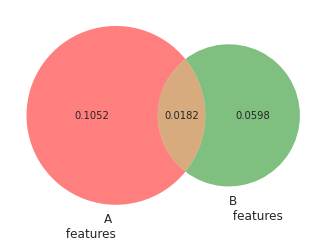

In [47]:
A = scores['base_U_adaptation']['non-cv']['raw_scores']
B = scores['prediction']['non-cv']['raw_scores']
AuB = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores']

plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True))

In [48]:
baseidx = np.where(map_val == 5)[0][100] # index pure baseline
mixidx = np.where(map_val == -2)[0][100] # fully mixed
predidx = np.where(map_val == -6)[0][0] # pure prediction
predbaseidx = np.where(map_val == 10)[0][1] # pred + adapt

NameError: name 'pimpcollors_venn2' is not defined

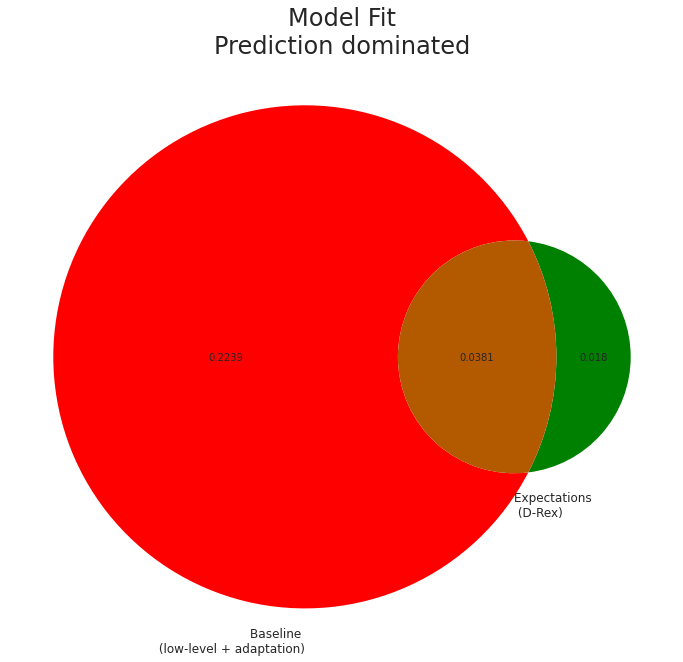

In [49]:
fontsize=20
fontsize_pct=fontsize-1
title_size=24
figsize=(12,12)
n_decim=3

idxtouse= predbaseidx

lbls=['Baseline \n (low-level + adaptation)','Expectations \n (D-Rex)']
correct_noise=False
save_fig=False

plt.figure(figsize=figsize)
plt.title('Model Fit\nPrediction dominated', fontsize=title_size)

A_sel   = A[idxtouse].clip(min=0)
B_sel   = B[idxtouse].clip(min=0)
AuB_sel = AuB[idxtouse].clip(min=0)

fg= plot_2way_varpartven(two_way_varpart(A_sel,B_sel,AuB_sel,correct_R2s=False,return_sep=True),
                     labels=lbls,avgfun=np.mean, alpha=1)

fg = pimpcollors_venn2(fg)


idrange = ['10', '01', '11']
for idx in idrange:
    try:
        label = fg.get_label_by_id(idx)
        label.set_fontsize(fontsize_pct) 
        label.set_text(str(np.round(float(label.get_text()), n_decim)))
        #label.set_text('') # easy way for empty ones
    except AttributeError: print(idx + 'not present')   
    
for labels in ['A', 'B']:
    label = fg.get_label_by_id(labels)
    label.set_fontsize(fontsize)
    if labels == 'C': label.set_x(label.get_position()[0] + 0.1)

if save_fig==True:
    fig_name=str(PROJ_ROOT / 'figures' / 'varpart' / 'readingtimes_average')
    for fmt in ['png','pdf']:
        plt.savefig(f'{fig_name}.{fmt}',facecolor='white',format=fmt)


In [ ]:
def pimpcollors_venn3(fig, 
                idrange=['100', '010', '001', '110', '101', '011', '111'], 
                colrange=['#b3b4b5', '#f68e65', '#8ca0ca', '#d5a18d', '#a0abc1', '#c39798', '#bca7a7']):
    """change collors of all elements of a venn diagram
    input: fig: figure
           idrange: range of all ellements of 3venn diagram
           colrange: matching to idrange, set collors for all ellements
    output: adjusted figure"""
    
    for i in range(len(idrange)):
        try: fig.get_patch_by_id(idrange[i]).set_color(colrange[i])
        except AttributeError: print(idrange[i] + 'not present')
    
    return(fig)

def pimpcollors_venn2(fig, 
                idrange=['10', '01', '11'], 
                colrange=['#EE6D4A', '#475DEC', '#9B659B']):
    """change collors of all elements of a venn diagram
    input: fig: figure
           idrange: range of all ellements of 3venn diagram
           colrange: matching to idrange, set collors for all ellements
    output: adjusted figure"""
    
    for i in range(len(idrange)):
        try: fig.get_patch_by_id(idrange[i]).set_color(colrange[i])
        except AttributeError: print(idrange[i] + 'not present')
    
    return(fig)

## Translate data to `vmp`

In [ ]:
## stranslate data to vmp

score_vmp_full = np.zeros((vmp_img.shape))

score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] * 100
score_vmp_full[:,:,:,0] = score_vmp

score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] * 100
score_vmp_full[:,:,:,1] = score_vmp

score_vmp_head = vmp_head.copy()

score_vmp_head['Map'][0]['MapName'] = 'medianscores'
score_vmp_head['Map'][1]['MapName'] = 'meanscores'

bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S01_SES1/Betas/newdata5.vmp',score_vmp_head, score_vmp_full)

### simulate voxels

In [ ]:
import itertools

# settings
bias_labels = ['adapthigh', 'expecthigh', 'equal', 'low-level']
bias = np.array([[0, 0, 1, 0, 0],   # adapthigh
                 [1, 0, 0, 0, 1],   # expecthigh
                 [1, 1, 1, 1, 1],   # equal
                 [0, 1, 0, 0, 0]])  # low level

# grid
sim_prefs = np.round(pref_range,4)[::40] # take few prefs
sim_sharps = np.round(sharp_range,4)[::4] # take few sharps

# predefine simulated voxels
simvoxels = np.zeros((len(bias), len(sim_prefs) * len(sim_sharps), len(tr_df)))

# go through the full grid
for b in range(len(bias)):
    
    # set linear indexing
    linidx = 0
    
    for prf, shr in itertools.product(sim_prefs, sim_sharps):
#         print(bias, prf, shr)
        
        # calculate the 
        sim_vtc = scipy.stats.zscore(tr_df[stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)].to_numpy())
        sim_vtc = (sim_vtc * bias[b]).sum(axis=1)
        
        # z-score + noise
        sim_vtc = zs(sim_vtc) + np.random.normal(0,0.4,len(sim_vtc))
        
        # place in array, adjust linidx
        simvoxels[b, linidx] = sim_vtc
        linidx += 1

In [ ]:
sim_vtc = scipy.stats.zscore(tr_df[stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)].to_numpy())
sim_vtc = (sim_vtc * bias[b]).sum(axis=1)

plt.plot(sim_vtc)

In [ ]:
# NEW METHOD - load all runs of chuck

# set chucking size
chucksize = 50000 #msk[0].shape[0]
chucktoanalyse = 0

# pp settings
nr_runs = 12
# pp = 2
ses = 2

# load only header information
head, _ = vtc.read_vtc_msk(fullpath, tuple((np.array([0]),
                                            np.array([0]),
                                            np.array([0]))))

# get expected vtc dim
vtcdim = vtc.get_vtc_dims(head)

# load full mask and convert to indeces
_, msk = bvbabel.msk.read_msk(mskpath)
msk = np.where(msk)

# devide the mask in chucks based on our chucksize
chucked_msk = vtc.chuck_msk(msk, chucksize)

# to loop over all chucks we can do
#for chuck in chucked_msk: # remove this - just for testing speed
chuck = chucked_msk[chucktoanalyse]

# predefine full image over runs
# y = np.zeros((msk[0].shape[0], vtcdim[-1], nr_runs))
y = np.zeros((chuck[0].shape[0], vtcdim[-1], nr_runs))
run_nr = np.zeros((vtcdim[-1], nr_runs))

for run in np.arange(0,nr_runs):
    # get current runpath
    fullpath = join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run+1))

    # mask the vtc
    _, y[:,:,run] = vtc.read_vtc_msk(fullpath, chuck)
    run_nr[:, run] = run + 1

# reshape into single dim
run_nr = run_nr.reshape((-1),order='F')
y = y.reshape((y.shape[0], -1), order='F').transpose()

In [ ]:
# preprecreat a empty image with the dimension
#  of the full vtc - for plotting purpuses
rec_img = np.zeros(vtc.get_vtc_dims(head))
    
# fill in chuck in reconstructed image
rec_img[chuck] = y[run_nr == 5].transpose()
    
# finaly show the full picture
plt.imshow(rec_img[:,:,20,100])

In [ ]:
# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True)

# artifically make longer
X = np.repeat(X, 1000, axis=0)
y = np.repeat(y, 1000)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
st_time = time.time()
regr.fit(X, y)
en_time = time.time()

# Make predictions using the testing set
y_pred = regr.predict(X) # on same

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

print(f"\n\nTime elepsed: {en_time - st_time}")

## test with multi output regression

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score

# # Load the diabetes dataset
# X, y = datasets.load_diabetes(return_X_y=True)

# # artifically make longer
# X = np.repeat(X, 10, axis=0)
# y = np.repeat(y, 10)

# # add muli output
# nr_outputs = 10000
# y_array = np.empty((len(y),nr_outputs))
# for i in range(nr_outputs):
#     noise = np.random.normal(0,1,len(y))
#     y_array[:,i] = (y + i) + noise

In [ ]:
# print(f"X_shape: {X.shape}, y_shape: {y_array.shape}")

In [ ]:
# # Create linear regression object
# regr = linear_model.LinearRegression()
# #regr = linear_model.Ridge()

# # Train the model using the training sets
# st_time = time.time()
# regr.fit(X, y_array)

# # Make predictions using the testing set
# y_pred = regr.predict(X) # on same

# en_time = time.time()

# # The coefficients
# print("Coefficients: \n", regr.coef_[:5,:])
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_array, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y_array, y_pred))

# print(f"\n\nTime elepsed: {en_time - st_time}")

### Naive approach, looping

In [ ]:
# # predefine y_ped to fill in later
# y_pred = np.empty(y_array.shape)
# coefs = np.empty((y_array.shape[1], X.shape[1]))

# # Create linear regression object
# regr = linear_model.LinearRegression()

# regdict = {}
# # Train the model using the training sets
# st_time = time.time()
# for i in range(y_array.shape[1]):
#     regr.fit(X, y_array[:,i])
#     y_pred[:,i] = regr.predict(X)
#     coefs[i,:] = regr.coef_
# en_time = time.time()

# # The coefficients
# print("Coefficients: \n", coefs[:5,:])
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_array, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y_array, y_pred))

# print(f"\n\nTime elepsed: {en_time - st_time}")